# Dataworth with Freyberg Zones Model

Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  Important things to remember:
- FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_zn()
working_dir = fs.WORKING_DIR_ZN
pst_name = fs.PST_NAME_ZN

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_zones_dataworth/freyberg_zn/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICA

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=5,master_dir=".")
os.chdir("..")

master:pestpp freyberg_zn.pst /h :4004 in .
slave:pestpp freyberg_zn.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_zn.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_zn.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_zn.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_zn.pst /h localhost:4004 in ../slave_4


In [5]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

A quick check of which parameters are being informed by the observations during calibration:

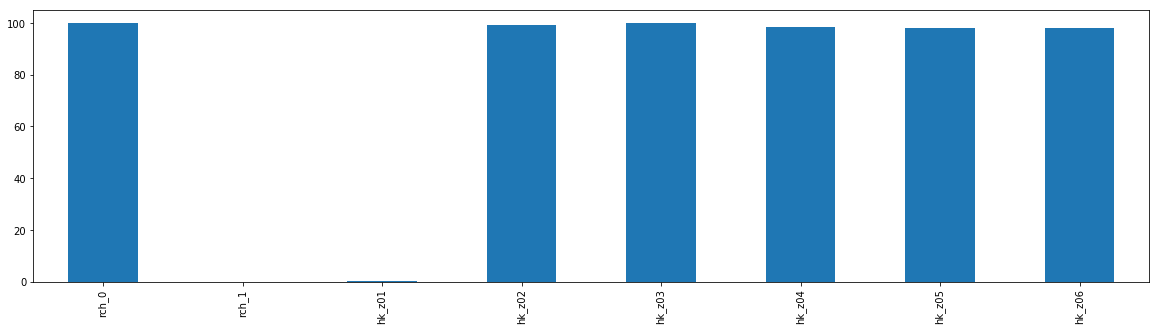

In [6]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [7]:
df_pc = sc.get_par_contribution()


In [8]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

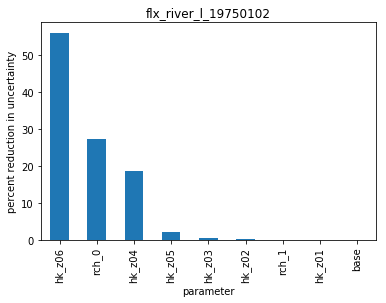

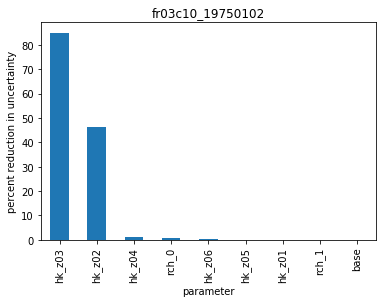

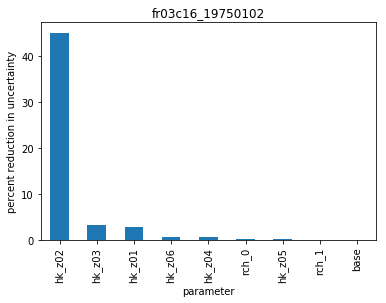

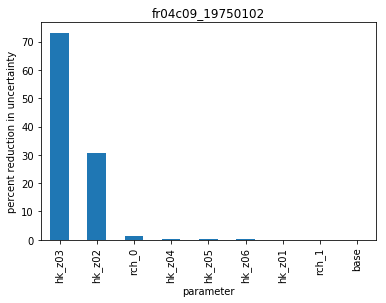

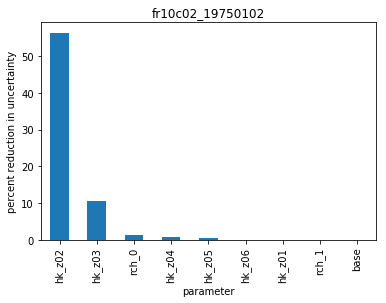

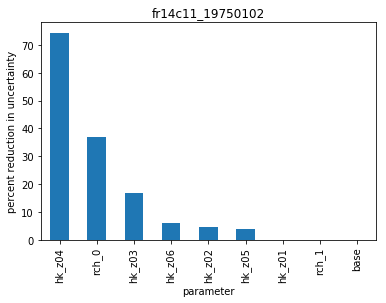

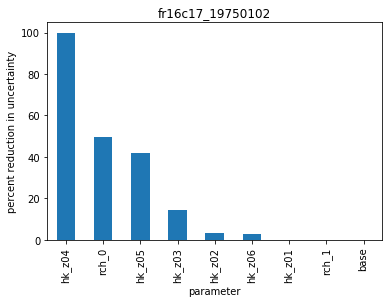

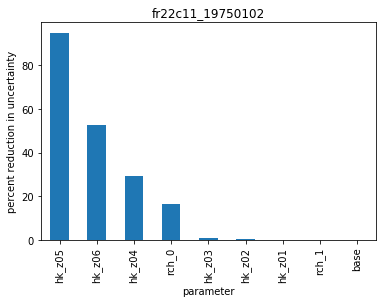

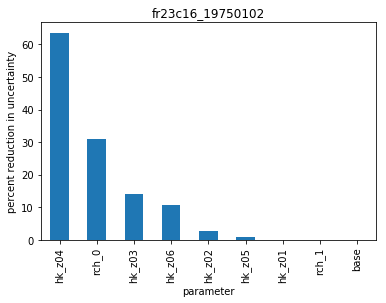

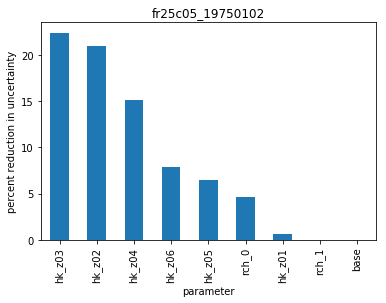

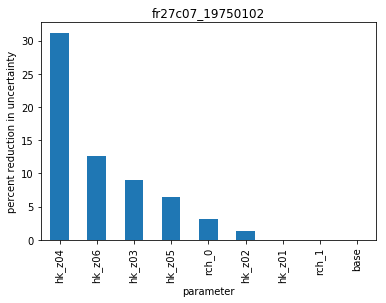

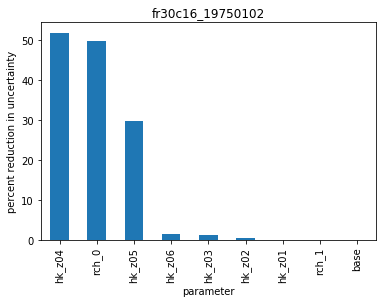

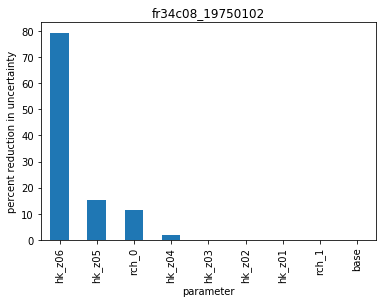

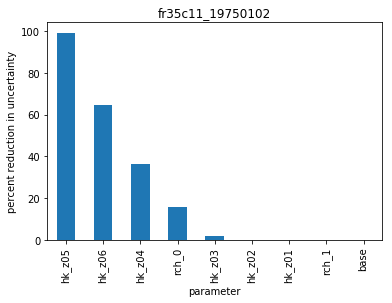

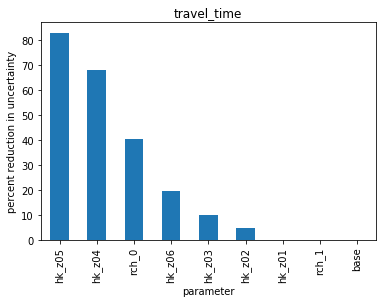

In [9]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

We see a mixture of HK zones and past and future recharge...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [10]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,travel_time
base,103.631606,0.009680,0.000033,0.008885,0.023939,0.004689,0.005028,0.015200,0.000715,0.008029,0.008536,0.000420,0.020213,0.004195,3.825480e+06
cr30c16_19700102,104.621094,0.009683,0.000033,0.008890,0.023946,0.004715,0.005085,0.015349,0.000717,0.008029,0.008541,0.000429,0.020311,0.004227,3.889087e+06
cr14c11_19700102,121.034771,0.009681,0.000033,0.008890,0.023958,0.006829,0.007151,0.015521,0.001025,0.008913,0.010044,0.000498,0.021358,0.004361,4.433164e+06
cr03c10_19700102,103.650486,0.017758,0.000033,0.016075,0.024002,0.004932,0.005191,0.015204,0.000748,0.010508,0.008774,0.000420,0.020279,0.004198,3.903922e+06
cr35c11_19700102,106.647291,0.009698,0.000033,0.008922,0.023980,0.004858,0.005743,0.018436,0.000727,0.008050,0.008536,0.000507,0.020268,0.004995,4.791383e+06
cr23c16_19700102,105.467606,0.009693,0.000033,0.008891,0.023941,0.004918,0.005225,0.015204,0.000749,0.008083,0.008698,0.000426,0.020352,0.004201,3.868887e+06
flx_river_l_19700102,424.530234,0.144781,0.000713,0.187640,0.600443,0.017848,0.007779,0.066960,0.002964,0.353997,0.239544,0.003520,0.110090,0.008861,1.545549e+07
cr25c05_19700102,104.120343,0.011123,0.000033,0.010229,0.023945,0.004979,0.005250,0.015245,0.000765,0.011564,0.010496,0.000424,0.020636,0.004200,3.831522e+06
cr16c17_19700102,112.107766,0.009709,0.000033,0.008889,0.024006,0.006197,0.007157,0.016968,0.000912,0.008593,0.009704,0.000510,0.020404,0.004815,4.893671e+06
cr27c07_19700102,105.123771,0.009850,0.000033,0.009008,0.023952,0.005815,0.005730,0.015558,0.000902,0.010036,0.013792,0.000438,0.021384,0.004195,3.826780e+06


In [11]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

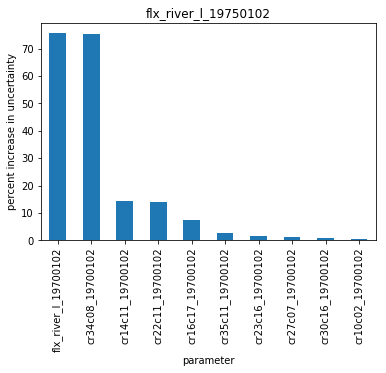

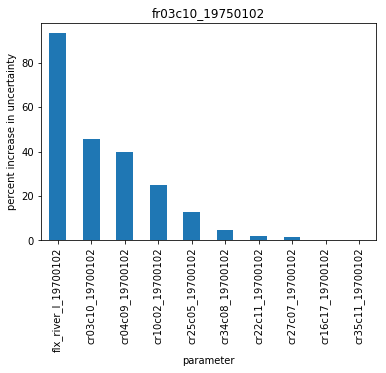

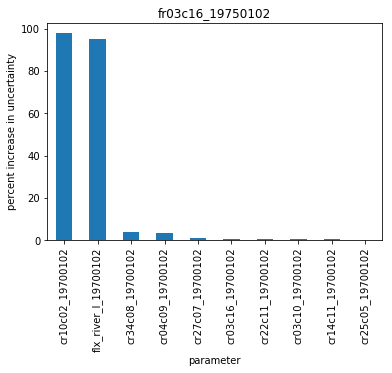

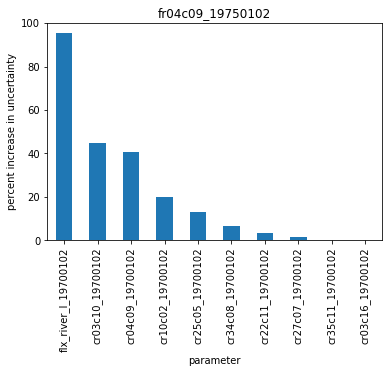

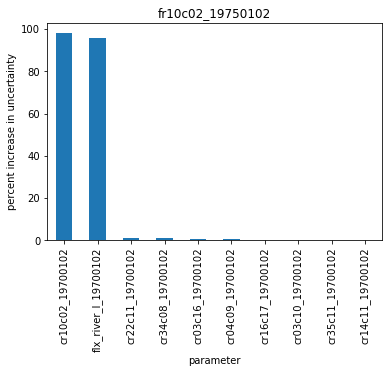

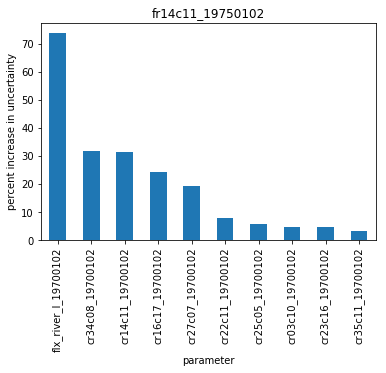

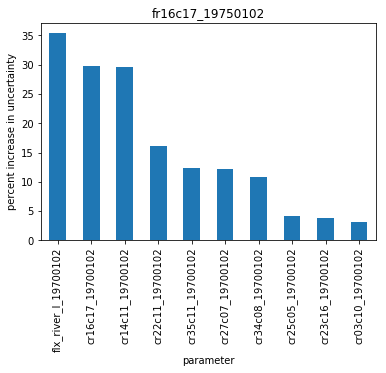

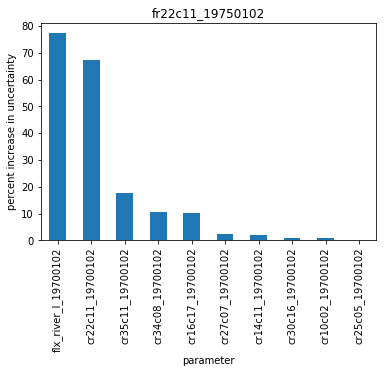

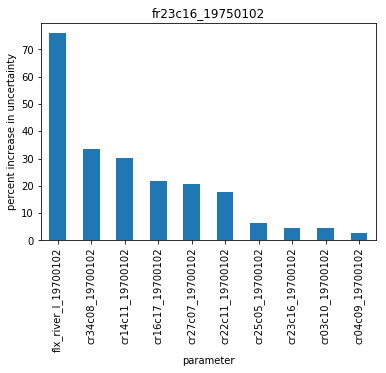

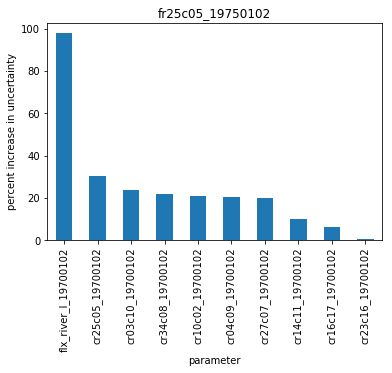

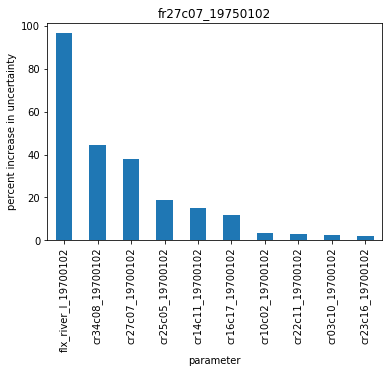

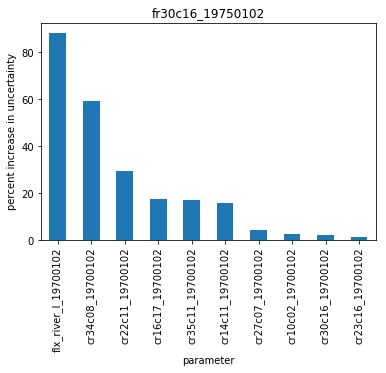

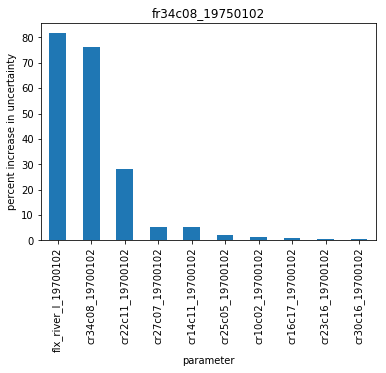

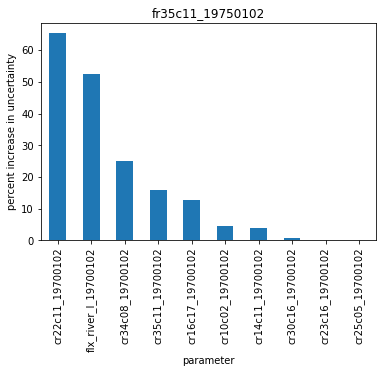

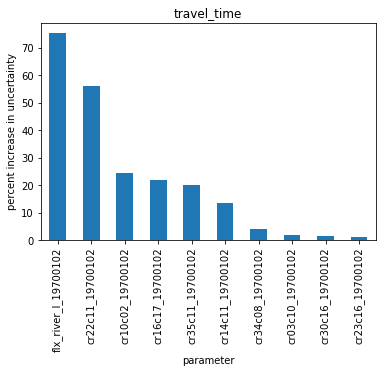

In [12]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [13]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr") and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [14]:
pobs_names

['pr01c01_19700102',
 'pr01c02_19700102',
 'pr01c03_19700102',
 'pr01c04_19700102',
 'pr01c05_19700102',
 'pr01c06_19700102',
 'pr01c07_19700102',
 'pr01c08_19700102',
 'pr01c09_19700102',
 'pr01c10_19700102',
 'pr01c11_19700102',
 'pr01c12_19700102',
 'pr01c13_19700102',
 'pr01c14_19700102',
 'pr01c15_19700102',
 'pr01c16_19700102',
 'pr01c17_19700102',
 'pr01c18_19700102',
 'pr01c19_19700102',
 'pr01c20_19700102',
 'pr02c01_19700102',
 'pr02c02_19700102',
 'pr02c03_19700102',
 'pr02c04_19700102',
 'pr02c05_19700102',
 'pr02c06_19700102',
 'pr02c07_19700102',
 'pr02c08_19700102',
 'pr02c09_19700102',
 'pr02c10_19700102',
 'pr02c11_19700102',
 'pr02c12_19700102',
 'pr02c13_19700102',
 'pr02c14_19700102',
 'pr02c15_19700102',
 'pr02c16_19700102',
 'pr02c17_19700102',
 'pr02c18_19700102',
 'pr02c19_19700102',
 'pr02c20_19700102',
 'pr03c01_19700102',
 'pr03c02_19700102',
 'pr03c03_19700102',
 'pr03c04_19700102',
 'pr03c05_19700102',
 'pr03c06_19700102',
 'pr03c07_19700102',
 'pr03c08_197

In [15]:
df_ad.min()

flx_river_l_19750102    9.889589e+01
fr03c10_19750102        9.445435e-03
fr03c16_19750102        3.113326e-05
fr04c09_19750102        8.700329e-03
fr10c02_19750102        2.275415e-02
fr14c11_19750102        4.605594e-03
fr16c17_19750102        4.884360e-03
fr22c11_19750102        1.348400e-02
fr23c16_19750102        7.035036e-04
fr25c05_19750102        7.853164e-03
fr27c07_19750102        8.242299e-03
fr30c16_19750102        4.075344e-04
fr34c08_19750102        1.856864e-02
fr35c11_19750102        3.661844e-03
travel_time             3.586054e+06
dtype: float64

In [16]:
df_ad.max()

flx_river_l_19750102    1.036316e+02
fr03c10_19750102        9.680309e-03
fr03c16_19750102        3.281359e-05
fr04c09_19750102        8.885182e-03
fr10c02_19750102        2.393893e-02
fr14c11_19750102        4.689427e-03
fr16c17_19750102        5.028208e-03
fr22c11_19750102        1.519980e-02
fr23c16_19750102        7.146994e-04
fr25c05_19750102        8.029251e-03
fr27c07_19750102        8.535864e-03
fr30c16_19750102        4.196107e-04
fr34c08_19750102        2.021348e-02
fr35c11_19750102        4.195485e-03
travel_time             3.825480e+06
dtype: float64

In [23]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[2:4])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7])-1)
    zn_arr = np.loadtxt(os.path.join(working_dir,"hk.zones"))
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(122,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        ax2 = plt.subplot(121,aspect="equal")
        
        c = ax2.pcolormesh(m.sr.xedge,m.sr.yedge,zn_arr)
        plt.colorbar(c)
        if forecast.startswith("fr"):
            i = int(forecast[2:4]) - 1
            j = int(forecast.split('_')[0].split('c')[-1]) - 1
            x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
            ax.scatter([x],[y],marker='o',color='r',s=150)
            ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax2.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax2.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.set_title(forecast)
        plt.show()
        plt.close(fig)
    

Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

fr03c10_19750102


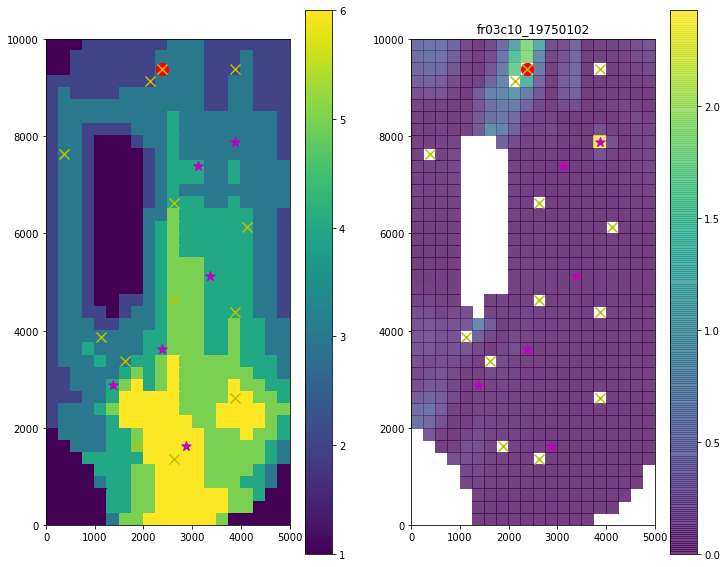

fr03c16_19750102


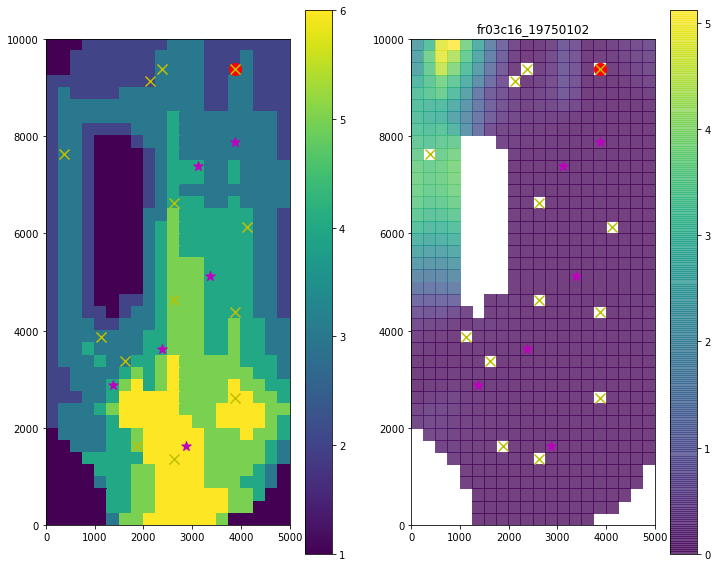

fr04c09_19750102


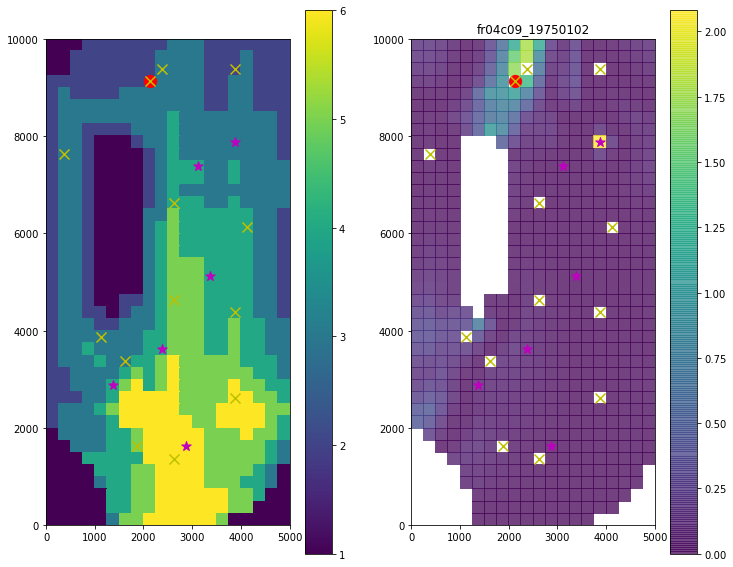

fr10c02_19750102


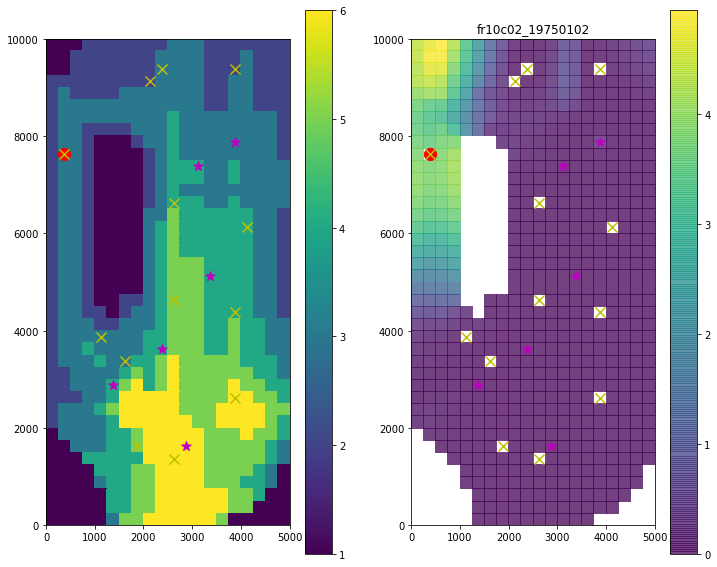

fr14c11_19750102


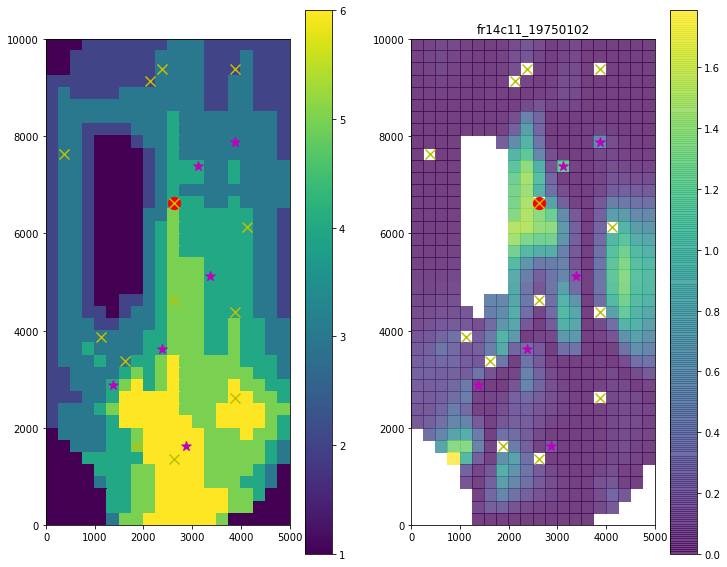

fr16c17_19750102


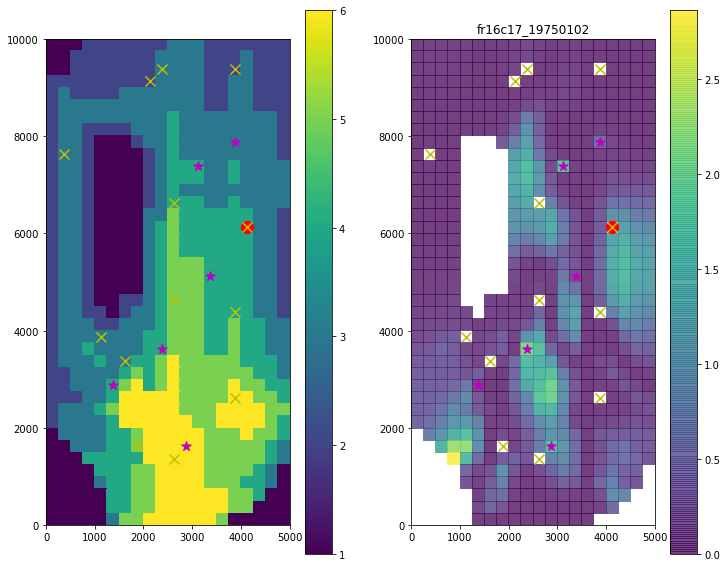

fr22c11_19750102


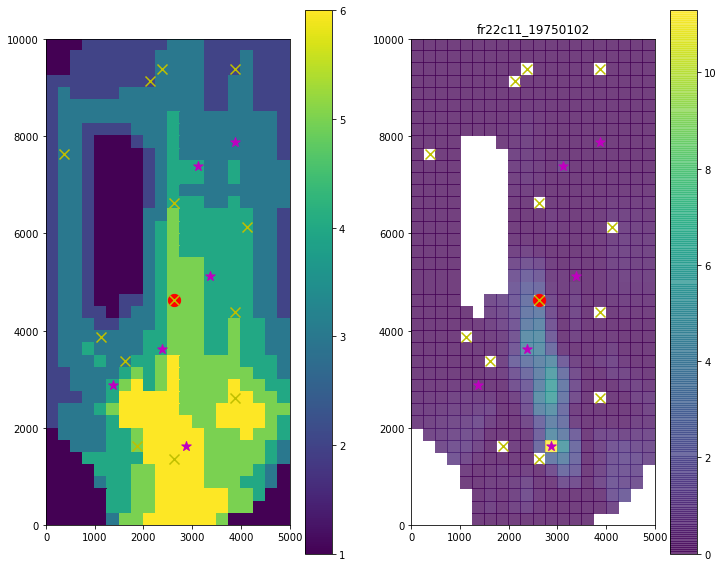

fr23c16_19750102


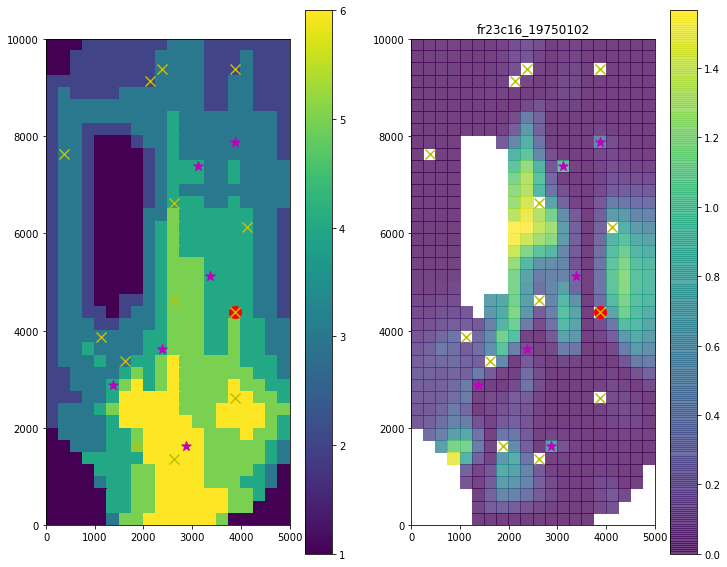

fr25c05_19750102


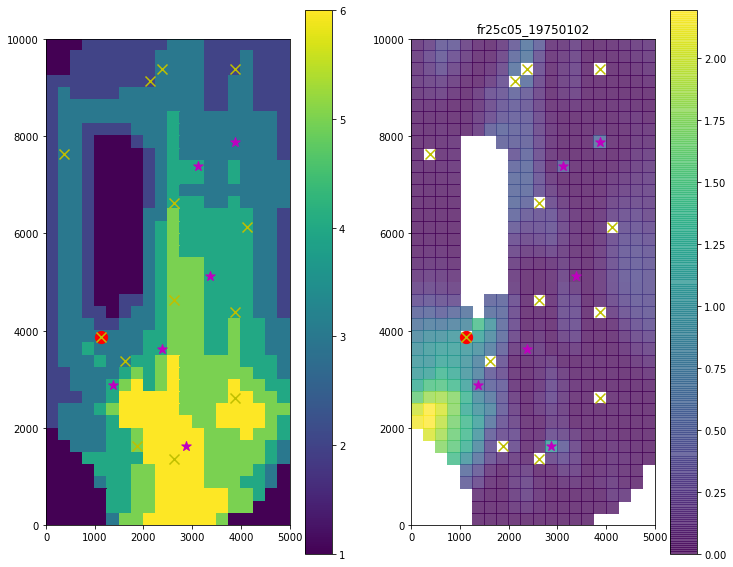

fr27c07_19750102


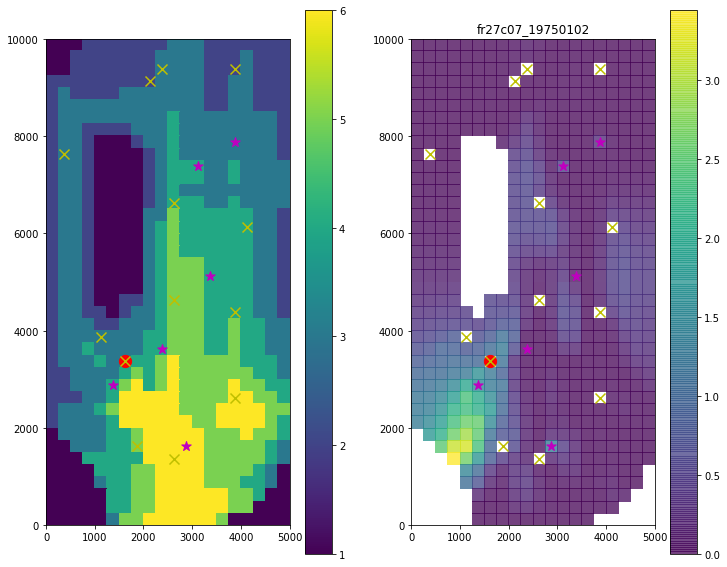

fr30c16_19750102


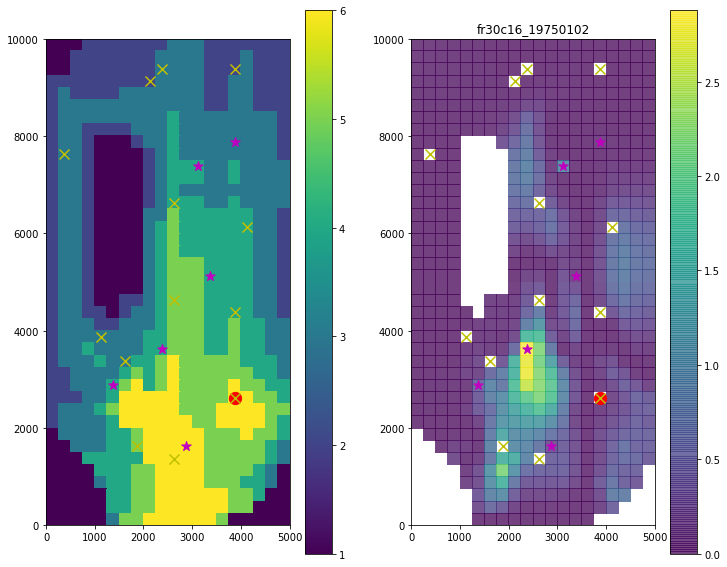

fr34c08_19750102


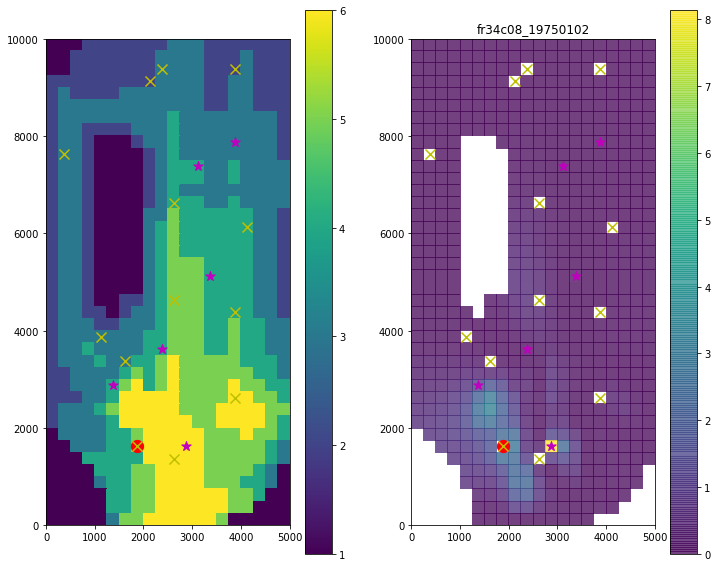

fr35c11_19750102


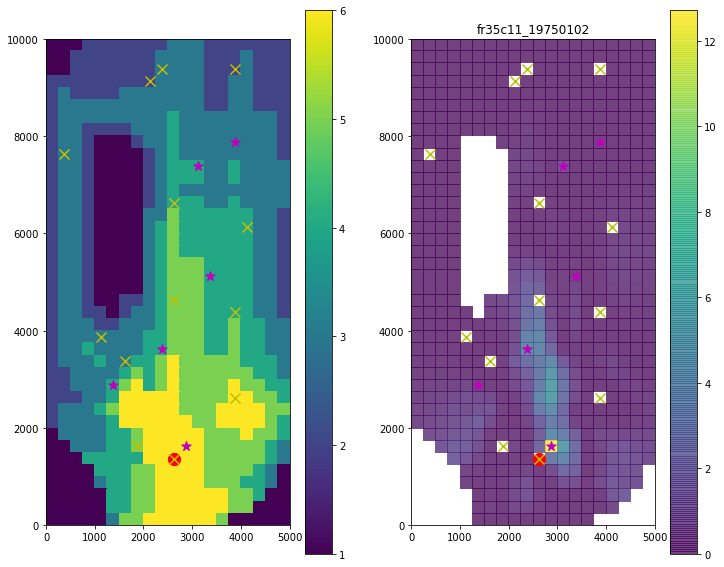

flx_river_l_19750102


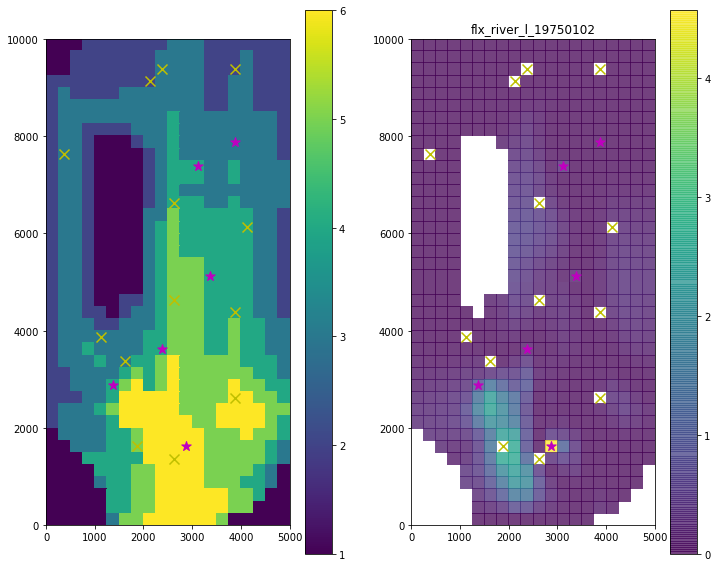

travel_time


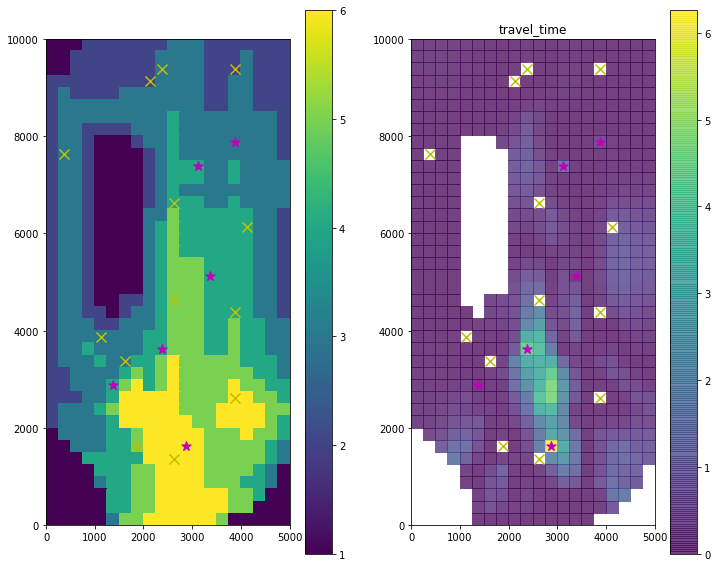

In [24]:
plot_added_worth(df_ad)

Those are kinda weird, right?  In many ways, these dataworth results seem to not follow common sense/physical meaning...why is that?